# End of season simulation with XGBoost - Clissifier

In case of uncertein future regarding end of season in european leagues I've tried to make some predictions of it by my own. To predict each game outocme I've used XGBoost model. All neccesserry code you can find below. If you would like to make some modification or try work on this script by your own, let me know and contact me on via my GitHub page: https://github.com/szydlinho

## Connect to database and download data

In [64]:
import pandas as pd
import os
import time
import pymysql
import psycopg2
import sklearn
import numpy as np

loc_to_functions =  "D:\data_football\Football_prediction_ML\Football_ML"
    
os.chdir(loc_to_functions)
        
import functions_for_dataset_preparation as f1

league_abb = 'E0'
number_of_MW = 10

connection_aws = psycopg2.connect(user = "###",
                                  password = "###",
                                  host = "###.rds.amazonaws.com",
                                  port = "5432",
                                  database = "###")
    #cursor_aws = connection_aws.cursor()
        
dataset = pd.read_sql('SELECT * FROM public."'+league_abb+'" WHERE "FTHG" is NOT NULL AND "FTAG" is NOT NULL', connection_aws)
dataset["Date"] =    pd.to_datetime(dataset.Date ,  format = "%Y-%m-%d") 

marketv =  pd.read_sql('SELECT * FROM public."budget_'+league_abb+'"', connection_aws)   
df_final = f1.dataset_preparation_HDA(dataset, league_abb, marketv)
    
df_final = df_final.drop('Mean_away_goals',axis=1)
df_final = df_final.dropna()


Raw dataset. 

Explonation of some abbriviations: 

HT - HomeTeam, AT -AwayTeam, 
GD - Goals Difference, 

Diff - difference of (..) between Home and Away team, 

FormPts - Points from 3 last games each team,  

ELO - http://clubelo.com/, 

H2H - Head to Head in last 3 games, 

Mean_goals - Mean value of goals for each team in match in given season,  

LP - League table position, 

FTR - Full time result (A- Away win, D- Draw), 

Total_diff - Market value of home team/Market value of away team

In [43]:
df_final.tail()

,HTGD,ATGD,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,DiffPts,DiffFormPts,DiffLP,Mean_home_goals,H2H_Diff,ELO_diff,Total_Diff,LP_Diff,FTR,Goals_mean_diff
4713,-0.448276,-0.551724,0,0,0,0,0,0,0,0,2,2.0,3,2.2176,-9,-22,1.119249,-1,A,1.34567
4714,0.413793,-0.172414,0,0,0,0,0,0,0,0,8,3.0,-5,1.6632,-9,106,1.583492,-5,H,-0.62561
4715,0.068966,-0.241379,0,0,0,0,0,0,0,0,10,0.0,-5,3.4848,3,140,1.960058,-8,H,2.75819
4716,0.137931,-0.793103,0,0,0,0,0,0,0,0,19,-2.0,0,1.3200,6,-23,0.756243,-14,H,1.17468
4717,-0.241379,-0.448276,0,0,0,0,0,0,0,0,9,3.0,1,0.7392,-3,84,0.903466,-5,H,-0.35071


Numerical veriables: HTGD, ATGD, DiffPts, DiffFormsPts, DiffLP, Mean_home_goals, HWG_Diff, ELO_diff, Total_Diff, LP_Diff, Goals_mean_diff. 

Veriables of both type: Integer and also float.

In addition we also have categorical  veriables such as  HTWinnStreak3 ... ATLossStreak5, which have two categories 0/1. Those could also be converted to logical type of veriable.

### Converting specifed veriables

In [44]:
df_final["FTR"] = df_final["FTR"].astype('category')

In [45]:
cols_to_cv = ['HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 
              'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
              'ATLossStreak3', 'ATLossStreak5']

In [46]:
for col in cols_to_cv:
    df_final[col] = df_final[col].astype('bool')

## Dataset spilt to train and test set

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('FTR',axis=1).reset_index(drop = True), 
            df_final['FTR'].reset_index(drop = True), test_size=0.20,     random_state=1)
    

## Simple XGBoost Classifiier model

In [58]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [59]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = y_pred

### Accuracy of model

In [60]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.01%


In [53]:
pd.DataFrame({"Veriable" : X_train.columns,
              "Importance of veriable": model.feature_importances_}).sort_values('Importance of veriable', ascending = False)[0:8]

,Veriable,Importance of veriable
12,DiffLP,0.155301
2,HTWinStreak3,0.066992
16,Total_Diff,0.060960
15,ELO_diff,0.060955
18,Goals_mean_diff,0.059234
0,HTGD,0.059069
11,DiffFormPts,0.059000
1,ATGD,0.057866


### Selecting important veriables

In [54]:
veriables = ['DiffLP', 'ELO_diff', 'ATLossStreak3', 'LP_Diff', 'ATGD', 'Goals_mean_diff', 'HTGD', 'DiffPts']

### Model with specified veriables

In [62]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train[veriables], y_train)
# make predictions for test data
y_pred = model.predict(X_test[veriables])
predictions = y_pred
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.27%


We have to models. Both of them are similar value of accuracy (68,01% and 67,27%). 
Despite that the second model is a little bit less accurated I choose this one.
The decline of accurate value is slight however this model has significantly less number of veriable which is desirable.

### New data to predict

In [65]:
predict = pd.read_sql('SELECT * FROM public."'+league_abb+'" WHERE "FTHG" is NULL AND "FTAG" is NULL', connection_aws)
predict["Date"] =    pd.to_datetime(predict.Date ,  format = "%Y-%m-%d") 
predict_mw = list(predict["MW"])[1]
predict_date =    predict.Date.astype('str')

marketv =  pd.read_sql('SELECT * FROM public."budget_'+league_abb+'"', connection_aws)      
#df_final.tail()
    
predict = f1.dataset_preparation_predict(predict, league_abb, marketv)

In [66]:
for col in cols_to_cv:
    predict[col] = predict[col].astype('bool')

In [67]:
y_pred_new = model.predict(predict[veriables])
y_pred_new_proba =  pd.DataFrame(model.predict_proba(predict[veriables]))   

In [68]:
df = pd.concat([pd.DataFrame(predict_date),
            predict[["HomeTeam", "AwayTeam"]].reset_index(drop=True), 
            pd.DataFrame(y_pred_new),
            y_pred_new_proba, predict[["Mean_home_goals", "Mean_away_goals"]].reset_index(drop=True)
           ], axis=1)

#0, 1, 2=['Away', 'Draw', 'Home']
df.drop_duplicates().tail()

,Date,HomeTeam,AwayTeam,0,0,1,2,Mean_home_goals,Mean_away_goals
13,2020-03-14,Man City,Burnley,H,0.001802,0.003518,0.994679,1.31126,0.75
14,2020-03-14,Norwich,Southampton,H,0.161414,0.071582,0.767004,1.31126,1.00
15,2020-03-15,Tottenham,Man United,H,0.066328,0.209096,0.724576,0.98344,1.25
16,2020-03-15,Watford,Leicester,H,0.217332,0.116342,0.666326,1.04901,0.96
17,2020-03-16,West Ham,Wolves,H,0.103754,0.355486,0.540760,1.83576,2.10


In [69]:
dataset_new =  pd.read_csv('https://www.football-data.co.uk/mmz4281/19-20'+
                            '/'+league_abb+'.csv', encoding = 'unicode_escape')
dataset_new = dataset_new.dropna(thresh=2) 
dataset_new["Date"]= pd.to_datetime(dataset_new.Date)

In [70]:
dataset_new[["HomeTeam", "AwayTeam", "FTR", "FTHG", "FTAG"]].head()

,HomeTeam,AwayTeam,FTR,FTHG,FTAG
0,Liverpool,Norwich,H,4,1
1,West Ham,Man City,A,0,5
2,Bournemouth,Sheffield United,D,1,1
3,Burnley,Southampton,H,3,0
4,Crystal Palace,Everton,D,0,0


In [71]:
fix_dict = pd.read_sql('SELECT * FROM public."fixtures_dictionary"', connection_aws)

In [72]:
#tables = pd.read_sql('''SELECT table_name  FROM information_schema.tables   WHERE table_schema!='public'  ''', connection_aws)

In [73]:
if league_abb == 'D1':
    fix = pd.read_csv('https://fixturedownload.com/download/bundesliga-2019-UTC.csv', encoding = 'utf-8')
elif league_abb == 'SP1':
    fix = pd.read_csv('https://fixturedownload.com/download/la-liga-2019-RomanceStandardTime.csv')
elif league_abb == 'F1':
    fix = pd.read_csv('https://fixturedownload.com/download/ligue-1-2019-RomanceStandardTime.csv')
elif league_abb == 'E1':
    fix = pd.read_csv('https://fixturedownload.com/download/championship-2019-GMTStandardTime.csv')
elif league_abb == 'I1':
    fix = pd.read_csv('https://fixturedownload.com/download/serie-a-2019-WEuropeStandardTime.csv')
elif league_abb == 'E0':
    fix = pd.read_csv('https://fixturedownload.com/download/epl-2019-GMTStandardTime.csv')

In [74]:
for i in range(0, len(fix)):
                if fix["Home Team"].iloc[i] in list(fix_dict.iloc[:,0]):
                    fix.loc[i, "Home Team"] = fix["Home Team"].iloc[i].replace(fix["Home Team"].iloc[i], str(fix_dict.iloc[:,1][fix_dict.iloc[:,0] == fix["Home Team"].iloc[i]].to_list()[0]))
                    
for i in range(0, len(fix)):
                if fix["Away Team"].iloc[i] in list(fix_dict.iloc[:,0]):
                    fix.loc[i, "Away Team"] = fix["Away Team"].iloc[i].replace(fix["Away Team"].iloc[i], str(fix_dict.iloc[:,1][fix_dict.iloc[:,0] == fix["Away Team"].iloc[i]].to_list()[0]))
                    
        
#dataset_new =dataset_new.merge( fix[["Home Team", "Away Team", "Round Number"]], left_on = ['HomeTeam','AwayTeam'], right_on = ['Home Team','Away Team'], how= 'right')

In [75]:
fix["FTHG"]=""
fix["FTAG"]=""
fix["FTR"]=""
for i in range(len(fix)):
    try:
        fix.loc[i, "FTHG"] = int(fix.loc[i, "Result"][0:1])
        fix.loc[i, "FTAG"] = int(fix.loc[i, "Result"][-1])
        
        if fix.loc[i, "FTHG"] > fix.loc[i, "FTAG"]:
            fix.loc[i, "FTR"] = "H"
        elif fix.loc[i, "FTHG"] < fix.loc[i, "FTAG"]:
            fix.loc[i, "FTR"] = "A"
        else:
            fix.loc[i, "FTR"] = "D"
    except:
        next

In [76]:
fix.head()

,Round Number,Date,Location,Home Team,Away Team,Result,FTHG,FTAG,FTR
0,1,09/08/2019 20:00,Anfield,Liverpool,Norwich,4 - 1,4,1,H
1,1,10/08/2019 12:30,London Stadium,West Ham,Man City,0 - 5,0,5,A
2,1,10/08/2019 15:00,Vitality Stadium,Bournemouth,Sheffield United,1 - 1,1,1,D
3,1,10/08/2019 15:00,Turf Moor,Burnley,Southampton,3 - 0,3,0,H
4,1,10/08/2019 15:00,Selhurst Park,Crystal Palace,Everton,0 - 0,0,0,D


In [77]:
dataset_old = pd.read_sql('SELECT * FROM public."'+league_abb+'"', connection_aws).sort_values(['Sezon', 'MW'])
    
# Print PostgreSQL Connection properties
#print ( connection.get_dsn_parameters(),"\n")

dataset_old['HTFormPtsStr'] = dataset_old['HM1'] + dataset_old['HM2'] + dataset_old['HM3'] + dataset_old['HM4'] + dataset_old['HM5']
dataset_old['ATFormPtsStr'] = dataset_old['AM1'] + dataset_old['AM2'] + dataset_old['AM3'] + dataset_old['AM4'] + dataset_old['AM5']
        
dataset_old['HTFormPts'] = dataset_old['HTFormPtsStr'].apply(f1.get_form_points)
dataset_old['ATFormPts'] = dataset_old['ATFormPtsStr'].apply(f1.get_form_points)
dataset_old['DiffFormPts'] = dataset_old['HTFormPts'] - dataset_old['ATFormPts']

In [78]:
dataset_new = fix[['Date', 'Home Team','Away Team' ,'FTR', 'FTHG', 'FTAG','Round Number' ]]
#dataset_final = pd.concat([dataset_old, playing_stat_new], sort=False)
dataset_new.rename(columns={"Round Number": "MW" , "Home Team" :"HomeTeam", "Away Team":"AwayTeam" }, inplace= True)

C:\Users\szydlikp\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [80]:
dataset_new.head()

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,MW
0,09/08/2019 20:00,Liverpool,Norwich,H,4,1,1
1,10/08/2019 12:30,West Ham,Man City,A,0,5,1
2,10/08/2019 15:00,Bournemouth,Sheffield United,D,1,1,1
3,10/08/2019 15:00,Burnley,Southampton,H,3,0,1
4,10/08/2019 15:00,Crystal Palace,Everton,D,0,0,1


In [81]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR', 'MW']
playing_stat_new = dataset_new[columns_req]
playing_stat_new = playing_stat_new.dropna()
playing_stat_new['HomeTeam'] = playing_stat_new['HomeTeam'].str.strip()
playing_stat_new['AwayTeam'] = playing_stat_new['AwayTeam'].str.strip()

In [82]:
names = pd.read_sql('SELECT * FROM public."names_dictionary"', connection_aws)
#names = pd.read_csv(dics + ":/data_football/dictionary.csv", sep = ";")
names = names.drop_duplicates()
names.columns = ["old", "new"]
names_dict = pd.Series(names.old.values,index=names.new).to_dict()
names_dict2 = pd.Series(names.new.values,index=names.old).to_dict()
   
    
Standings =  pd.read_sql('SELECT * FROM public."standings_'+league_abb+'"', connection_aws)
#pd.read_csv(dics + ':/data_football/tables_positions/'+ names_dict[league_abb] +'.csv', header=0)
Standings.set_index(['Team'], inplace=True)
Standings = Standings.fillna(round(number_of_MW*2*0.75))

In [83]:
playing_stat_new.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,MW
375,17/05/2020 15:00,Leicester,Man United,,,,38
376,17/05/2020 15:00,Man City,Norwich,,,,38
377,17/05/2020 15:00,Newcastle,Liverpool,,,,38
378,17/05/2020 15:00,Southampton,Sheffield United,,,,38
379,17/05/2020 15:00,West Ham,Aston Villa,,,,38


In [84]:
#playing_stat_new.loc[playing_stat_new["MW"]==kolejka, ['FTR', 'FTHG','FTAG']] = ''
#playing_stat_new.loc[(playing_stat_new["MW"]==28) & (playing_stat_new["HomeTeam"]=='Aston Villa') , 'FTR'] = 'H'
#playing_stat_new.loc[(playing_stat_new["MW"]==28) & (playing_stat_new["HomeTeam"]=='Aston Villa') , 'FTHG'] = int(2)
#playing_stat_new.loc[(playing_stat_new["MW"]==28) & (playing_stat_new["HomeTeam"]=='Aston Villa') , 'FTAG'] = int(1)

mw_for_loop = playing_stat_new.loc[playing_stat_new["FTR"]=="", "MW"].unique()

playing_stat_new.Date = pd.to_datetime(playing_stat_new.Date ,  format = "%d/%m/%Y %H:%M")
playing_stat_new.Date = pd.to_datetime(playing_stat_new.Date,  format = "%Y-%m-%d")

# Elo ranking
names_elo = pd.read_sql('SELECT * FROM public."dictionary_elo"', connection_aws)
# names_elo = pd.read_csv(dics + ":/data_football/dictionary_elo.csv", sep = ";", header = None)
names_elo = names_elo.drop_duplicates()
names_elo.columns = ["old", "new"]
names_dict_elo = pd.Series(names_elo.new.values, index=names_elo.old).to_dict()

## Simulation rest of season

In [85]:

for kolejka in mw_for_loop:
    fixtures = playing_stat_new.loc[(playing_stat_new["MW"]==kolejka) & (playing_stat_new["FTR"] == '')]
    fixtures.reset_index(drop=True, inplace=True)
    fixtures.Date = pd.to_datetime(fixtures.Date)
    #fixtures = playing_stat_new.append(fixtures, sort=False)
    if len(fixtures)<number_of_MW:
        fixtures = playing_stat_new.loc[(playing_stat_new["MW"]==kolejka) ]
        fixtures[["FTHG", 'FTAG', 'FTR']] = ''
    #fixtures.reset_index(drop=True, inplace=True)
    fixtures = playing_stat_new.loc[playing_stat_new["MW"]<kolejka,].append(fixtures, sort=False)
    fixtures = fixtures.drop_duplicates()
    #'16/08/2019 21:00' '%Y %d %b %H:%M'
    fixtures.Date = pd.to_datetime(fixtures.Date ,  format = "%d/%m/%Y %H:%M")
    fixtures.reset_index(inplace=True, drop = True)
    fixtures.sort_values(["MW", "Date"], inplace = True)
    fixtures.replace('', np.nan, inplace=True)
    fixtures["FTHG"] = fixtures["FTHG"].astype('Int32')
    fixtures["FTAG"] = fixtures["FTAG"].astype('Int32')
    fixtures = f1.get_gss(fixtures, number_of_MW)
    fixtures = f1.get_agg_points(fixtures, number_of_MW)
    fixtures = f1.get_agg_wins(fixtures, number_of_MW)
    fixtures = f1.get_agg_losses(fixtures, number_of_MW)
    fixtures = f1.get_agg_draws(fixtures, number_of_MW)
    fixtures = f1.add_form_df(fixtures, number_of_MW)
    fixtures.reset_index(inplace=True, drop=True) 
    f1.standings_live(fixtures, number_of_MW)
    fixtures = f1.get_last(fixtures, Standings, "2019")
    fixtures['HTFormPtsStr'] = fixtures['HM1'] + fixtures['HM2'] #+ fixtures['HM3'] + fixtures['HM4'] + fixtures['HM5']
    fixtures['ATFormPtsStr'] = fixtures['AM1'] + fixtures['AM2'] #+ #fixtures['AM3'] + fixtures['AM4'] + fixtures['AM5']
          
    fixtures['HTFormPts'] = fixtures['HTFormPtsStr'].apply(f1.get_form_points)
    fixtures['ATFormPts'] = fixtures['ATFormPtsStr'].apply(f1.get_form_points)
            
    # Get Goal Difference
    fixtures['HTGD'] = fixtures['HTGS'] - fixtures['HTGC']
    fixtures['ATGD'] = fixtures['ATGS'] - fixtures['ATGC']
          
    # Diff in points
    fixtures['DiffPts'] = fixtures['HTP'] - fixtures['ATP']
    fixtures['DiffFormPts'] = fixtures['HTFormPts'] - fixtures['ATFormPts']
         
    # Diff in last year positions
    fixtures['DiffLP'] = fixtures['HomeTeamLP'] - fixtures['AwayTeamLP']
           
    fixtures['HTWinStreak3'] = fixtures['HTFormPtsStr'].apply(f1.get_3game_ws)
    fixtures['HTWinStreak5'] = fixtures['HTFormPtsStr'].apply(f1.get_5game_ws)
    fixtures['HTLossStreak3'] = fixtures['HTFormPtsStr'].apply(f1.get_3game_ls)
    fixtures['HTLossStreak5'] = fixtures['HTFormPtsStr'].apply(f1.get_5game_ls)
    fixtures['HTDrawStreak3'] = fixtures['HTFormPtsStr'].apply(f1.get_3game_ds)
    fixtures['HTDrawStreak5'] = fixtures['HTFormPtsStr'].apply(f1.get_5game_ds)
            
    fixtures['ATWinStreak3'] = fixtures['ATFormPtsStr'].apply(f1.get_3game_ws)
    fixtures['ATWinStreak5'] = fixtures['ATFormPtsStr'].apply(f1.get_5game_ws)
    fixtures['ATLossStreak3'] = fixtures['ATFormPtsStr'].apply(f1.get_3game_ls)
    fixtures['ATLossStreak5'] = fixtures['ATFormPtsStr'].apply(f1.get_5game_ls)
    fixtures['ATDrawStreak3'] = fixtures['ATFormPtsStr'].apply(f1.get_3game_ds)
    fixtures['ATDrawStreak5'] = fixtures['ATFormPtsStr'].apply(f1.get_5game_ds)

    fixtures["Date"] = pd.to_datetime(fixtures["Date"], format="%Y-%m-%d")

    fixtures["Sezon"] = 20

    final = pd.concat([dataset_old, fixtures], ignore_index=True, sort=False)
    final["Date"] = pd.to_datetime(final["Date"], format="%Y-%m-%d")
    final = final.drop_duplicates()
    # final.isnull().sum()

    f1.h2h_add(final)
    f1.get_points_h2h_add(final, "H2H_Home")
    f1.get_points_h2h_add(final, "H2H_Away")
    f1.off_and_deff_add(final)

    cols_final = ["Date", "HomeTeam", "AwayTeam", "FTR", "FTHG", "FTAG", "HTGS", "ATGS", "HTGC",
                  "ATGC", "HTP", "ATP", "HT_Wins", "AT_Wins", "HT_Loss",
                  "AT_Loss", "HT_Draws", "AT_Draws", 'HM1', 'AM1', 'HM2', 'AM2', 'HM3',
                  'AM3', 'HM4', 'AM4', 'HM5', 'AM5', "MW", "HomeTeamLP", "AwayTeamLP", "Sezon",
                  "HT_LP", "AT_LP", 'HTFormPtsStr', 'ATFormPtsStr', "HTFormPts", "ATFormPts", "HTWinStreak5",
                  'HTWinStreak3', 'HTLossStreak3',
                  'HTLossStreak5', 'HTDrawStreak3', 'HTDrawStreak5', 'ATWinStreak3',
                  'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'ATDrawStreak3',
                  'ATDrawStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP',
                  'H2H_Home', 'H2H_Away',
                  'H2H_Home_pts', 'H2H_Away_pts', 'Off_H', 'Off_A', 'Deff_H', 'Deff_A',
                  'temp',
                  'Mean_home_goals', 'Mean_away_goals',
                  'Elo_HT', 'Elo_AT']

    final = final[cols_final]


    final.Date = pd.to_datetime(final.Date)
    temp = final.loc[final['MW'] == 1]

    location = int(temp.apply(pd.Series.last_valid_index)["Elo_HT"])
    # if len(temp) % number_of_MW == 0:
    for i in range(len(temp.loc[:location, ]), len(temp), number_of_MW):
        # .strftime("%Y-%m-%d")
        date = str(str(temp["Date"].iloc[i].year) + '-09-20')
        sezon = temp["Sezon"].iloc[i]
        elo = pd.read_csv('http://api.clubelo.com/' + date)[["Club", "Elo"]]

        for ind in final.loc[final["Sezon"] == sezon].index.tolist():
            if final["HomeTeam"].iloc[ind] in elo.Club.tolist():
                final.iloc[ind, final.columns.get_loc("Elo_HT")] = int(
                    elo.loc[elo["Club"] == final["HomeTeam"].iloc[ind]]["Elo"])
            elif final["HomeTeam"].iloc[ind] not in elo.Club.tolist():
                final.iloc[ind, final.columns.get_loc("Elo_HT")] = int(
                    elo.loc[elo["Club"] == names_dict_elo[final["HomeTeam"].iloc[ind]]]["Elo"])

            if final["AwayTeam"].iloc[ind] in elo.Club.tolist():
                final.iloc[ind, final.columns.get_loc("Elo_AT")] = \
                    int(elo.loc[elo["Club"] == final["AwayTeam"].iloc[ind]]["Elo"])
            elif final["AwayTeam"].iloc[ind] not in elo.Club.tolist():
                final.iloc[ind, final.columns.get_loc("Elo_AT")] = \
                    int(elo.loc[elo["Club"] == names_dict_elo[final["AwayTeam"].iloc[ind]]]["Elo"])

    predict = final.loc[(final["FTR"].isna()) & (final["MW"] == kolejka) ]
    predict.drop_duplicates(inplace=True)
    predict["Date"] = pd.to_datetime(predict.Date, format="%Y-%m-%d")
    predict_mw = list(predict["MW"])[1]
    predict_date = predict.Date.astype('str')


    # df_final.tail()

    marketv = pd.read_sql('SELECT * FROM public."budget_' + league_abb + '"', connection_aws)
    predict = f1.dataset_preparation_predict_HDA(predict, league_abb, marketv)

    # In[187]:

    for col in cols_to_cv:
        predict[col] = predict[col].astype('bool')

    # In[188]:

    y_pred_new = model.predict(predict[veriables])
    y_pred_new_proba = pd.DataFrame(model.predict_proba(predict[veriables]))

    # In[189]:

    df = pd.concat([pd.DataFrame(predict_date).reset_index(drop=True),
                    predict[["HomeTeam", "AwayTeam"]].reset_index(drop=True),
                    pd.DataFrame(y_pred_new),
                    y_pred_new_proba, predict[["Mean_home_goals", "Mean_away_goals"]].reset_index(drop=True)
                    ], axis=1)
    
    df.columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'Away', 'Draw', 'Home', 'Mean_home_goals', 'Mean_away_goals']
    for mecz_id in range(len(df)):
        if list(playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                             (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTR"])[0] == "":
            playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                 (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTR"] =  df.loc[mecz_id, "FTR"]
            if  (df.loc[mecz_id, "FTR"] == "H") & (round(df.loc[mecz_id, "Mean_home_goals"]) > round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]))
            elif  (df.loc[mecz_id, "FTR"] == "H") & (round(df.loc[mecz_id, "Mean_home_goals"]) == round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]) + 1)
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]))
            elif  (df.loc[mecz_id, "FTR"] == "H") & (round(df.loc[mecz_id, "Mean_home_goals"]) < round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]) + 1)
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]) - 1)
            elif  (df.loc[mecz_id, "FTR"] == "A") & (round(df.loc[mecz_id, "Mean_home_goals"]) < round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]))
            elif  (df.loc[mecz_id, "FTR"] == "A") & (round(df.loc[mecz_id, "Mean_home_goals"]) == round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]) + 1)
            elif  (df.loc[mecz_id, "FTR"] == "A") & (round(df.loc[mecz_id, "Mean_home_goals"]) > round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]) - 1)
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]) + 1)
            elif  (df.loc[mecz_id, "FTR"] == "D") & ((round(df.loc[mecz_id, "Mean_home_goals"])  > round(df.loc[mecz_id, "Mean_away_goals"])) |
                                                     (round(df.loc[mecz_id, "Mean_home_goals"])  < round(df.loc[mecz_id, "Mean_away_goals"]))):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
            elif  (df.loc[mecz_id, "FTR"] == "D") & (round(df.loc[mecz_id, "Mean_home_goals"]) == round(df.loc[mecz_id, "Mean_away_goals"])):
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTHG"] = int(round(df.loc[mecz_id, "Mean_home_goals"]))
                playing_stat_new.loc[(playing_stat_new["HomeTeam"] == df.loc[mecz_id, "HomeTeam"]) &
                                     (playing_stat_new["AwayTeam"] == df.loc[mecz_id, "AwayTeam"]), "FTAG"] = int(round(df.loc[mecz_id, "Mean_away_goals"]))
        else:
            next

    print("Kolejka:" + str(kolejka))


C:\Users\szydlikp\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\szydlikp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\szydlikp\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Kolejka:28
Kolejka:29
Kolejka:30
Kolejka:31
Kolejka:32
Kolejka:33
Kolejka:34
Kolejka:35
Kolejka:36
Kolejka:37
Kolejka:38


In [86]:
playing_stat_new.to_csv('Final_dataset'+league_abb+'.csv')
#playing_stat_new = pd.read_csv('Final_dataset'+league_abb+'.csv')

dd = playing_stat_new
dd = f1.get_gss2(dd, number_of_MW)
dd = f1.get_agg_points2(dd, number_of_MW)
f1.standings_live(dd, number_of_MW)

HTDF = dd[ ['HomeTeam', 'HT_LP', 'HTP', 'HTGS', 'HTGC', 'MW']]
ATDF = dd[ ['AwayTeam', 'AT_LP', 'ATP', 'ATGS', 'ATGC', 'MW']]
HTDF.columns =  ATDF.columns = ['Team',  'Position', 'Points', 'GoalsScored', 'GoalsConceded', 'MW']

In [87]:
to_plot = pd.concat([HTDF, ATDF])
to_plot.drop_duplicates(inplace=True)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

dff = to_plot[to_plot['MW'].eq(38)].sort_values(by='Points', ascending=True)


pl = ['#c8102E', '#6CABDD', '#034694', '#DA291C', '#132257', '#003090', '#5199FF', '#E20338', '#FFD600', '#0071b9',
 '#0761af',
 '#0BB363', '#d91a21', '#b4053f', '#a61b2b', '#E20613', '#921b88', '#8ac3ee', '#0c1f6e', '#007fc8']
ll =     ['#a50044', '#FEBE10', '#272e61', '#ee3524', '#c79100', '#4A69FF', '#5199FF', '#E20338', '#FFD600', '#0071b9', '#0761af',
     '#0BB363', '#d91a21', '#b4053f', '#a61b2b', '#E20613', '#921b88', '#8ac3ee', '#0c1f6e', '#007fc8']

colors = dict(zip(
    list(dff.sort_values('Position')["Team"]),
    pl
))



In [88]:

def draw_barchart(MW):
    dff = to_plot[to_plot['MW'].eq(MW)].sort_values(by='Points', ascending=True)
    dff = dff.drop_duplicates(inplace=False)
    ax.clear()
    ax.barh(dff['Team'], dff['Points'],  color=[colors[x] for x in dff['Team']]  )
    for i, (value, name) in enumerate(zip(dff['Points'], dff['Team'])):
        ax.text(value, i, name, ha='right')  # Tokyo: name
        ax.text(value, i, value, ha='left')  # 38194.2: value
    # Add year right middle portion of canvas
    # ... polished styles
    ax.text(1, 0.4,  MW, transform=ax.transAxes, size=46, ha='right')
    ax.text(0, 1.06, 'Points', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Premier League simulation 2019/20',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by @szydlinho;', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

# Points at the end of season Premier League

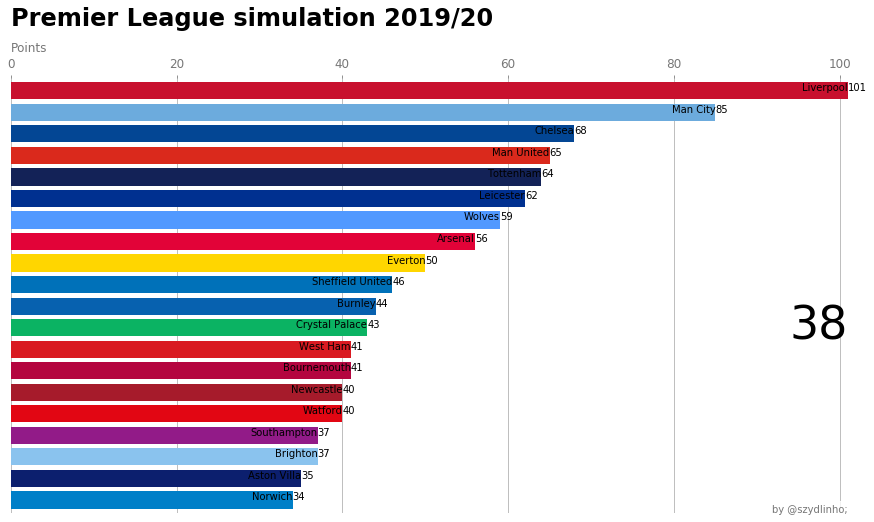

In [89]:
fig, ax = plt.subplots(figsize=(15, 8))
draw_barchart(38)


# Animation of points in Premier League 2019/20

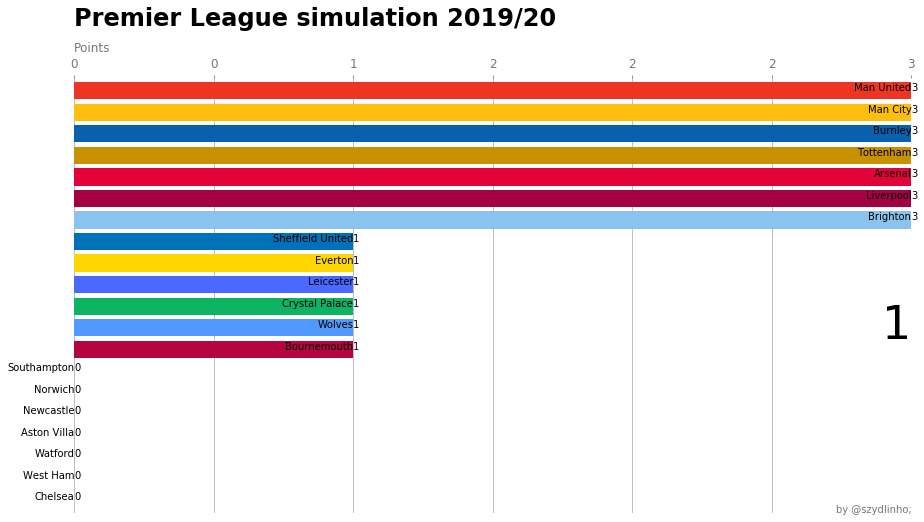

In [38]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 38))
HTML(animator.to_jshtml())

In [90]:
teams = dff['Team'].unique()

to_plot.sort_values(['MW', 'Team'], inplace = True)

# Position in table - Premier League 2019/20 in each Match Week

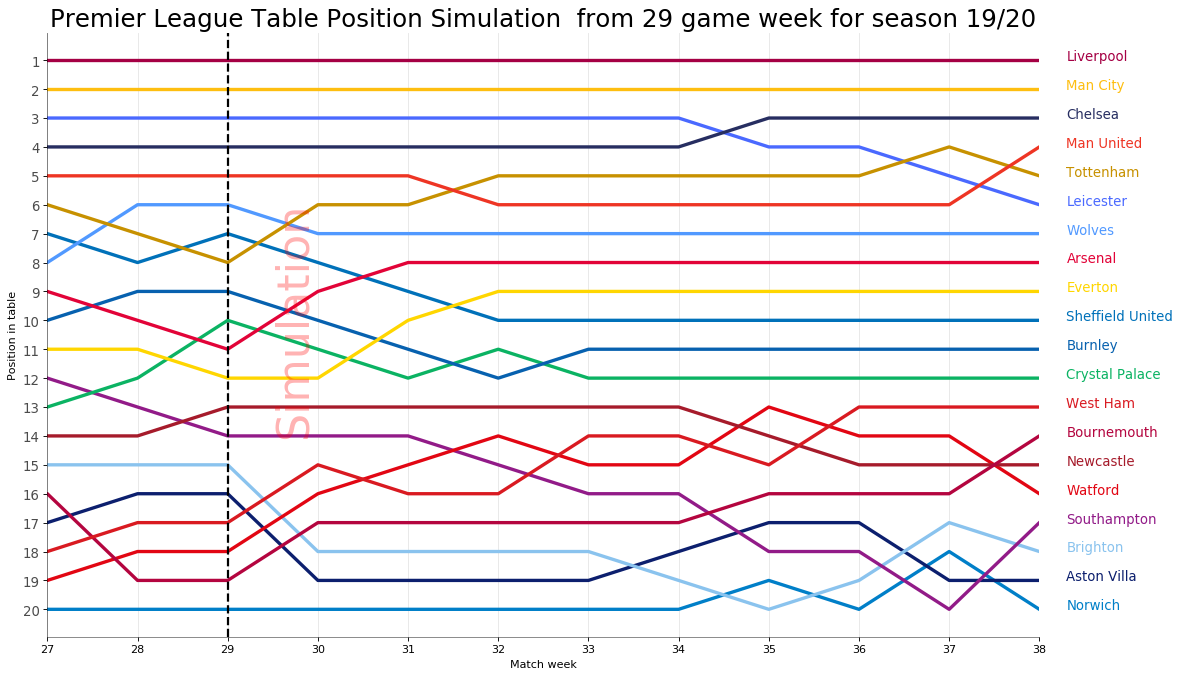

In [40]:
plt.figure(figsize=(16,10), dpi= 80)
for  y in teams:
    plt.plot('MW', 'Position', data=to_plot.loc[to_plot.Team==y, :], color=colors[y], label=y, linewidth = 3)
    plt.text(38+0.3, to_plot.loc[to_plot.Team==y, 'Position'][-1:].values[0], y, fontsize=12, color=colors[y])
plt.yticks(np.arange(1, 21, step=1))
plt.gca().invert_yaxis()
# Decoration

plt.xlim(27, 38)
plt.xticks(np.arange(27, 39, step=1))
plt.ylabel('Position in table')
plt.xlabel('Match week')
plt.axvline(29,  label='pyplot vertical line', c= 'black', linestyle='--', linewidth = 2)
plt.text(29.5, 10, 'Simulation', rotation=90, va='center',  fontsize= 40, alpha = 0.3, c= 'red')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Premier League Table Position Simulation  from 29 game week for season 19/20", fontsize=22)
plt.grid(axis='x', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.5)
# plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.show()
